In [39]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate

In [40]:
from pynq import PL
PL.reset() #important fixes caching issues which have popped up.
from pynq import Overlay  #import the overlay module
ol = Overlay('./design_1.bit')  #locate/point to the bit file

In [41]:
import pprint
pprint.pprint(ol.ip_dict)

{'axi_dma_0': {'addr_range': 65536,
               'bdtype': None,
               'device': <pynq.pl_server.embedded_device.EmbeddedDevice object at 0xffff97d4e920>,
               'driver': <class 'pynq.lib.dma.DMA'>,
               'fullpath': 'axi_dma_0',
               'gpio': {},
               'interrupts': {},
               'mem_id': 'S_AXI_LITE',
               'memtype': 'REGISTER',
               'parameters': {'ADDR_WIDTH': '10',
                              'ARUSER_WIDTH': '0',
                              'AWUSER_WIDTH': '0',
                              'BUSER_WIDTH': '0',
                              'CLK_DOMAIN': 'design_1_zynq_ultra_ps_e_0_1_pl_clk0',
                              'C_BASEADDR': '0xA0000000',
                              'C_DLYTMR_RESOLUTION': '125',
                              'C_ENABLE_MULTI_CHANNEL': '0',
                              'C_FAMILY': 'zynquplus',
                              'C_HIGHADDR': '0xA000FFFF',
                          

                                                                                  'result '
                                                                                  'in '
                                                                                  'undefined '
                                                                                  'behavior. \n'}},
                                             'size': 32},
                             'S2MM_TAILDESC': {'access': 'read-write',
                                               'address_offset': 64,
                                               'description': 'S2MM DMA Tail '
                                                              'Descriptor '
                                                              'Pointer '
                                                              'Register',
                                               'fields': {'Tail_Descriptor_Pointer': {'access': 'read-write',
               

                                               'fields': {'Tail_Descriptor_Pointer': {'access': 'read-write',
                                                                                      'bit_offset': 6,
                                                                                      'bit_width': 26,
                                                                                      'description': 'Indicates '
                                                                                                     'the '
                                                                                                     'pause '
                                                                                                     'pointer '
                                                                                                     'in '
                                                                                                     'a '
                           

In [42]:
from pynq import Clocks
Clocks.pl_clk0_mhz = 150
print(Clocks.pl_clk0_mhz)

150


In [43]:
N = 8192
num_width = 32

In [44]:
def get_twos_from_decimal(decimal, num_bits):
    if decimal >= 0:
        return decimal
    else:
        return decimal + (1<<num_bits)

In [45]:
def get_value_from_complex(real, imag, num_bits):
    real = int(real)
    imag = int(imag)
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

In [46]:
def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos

In [47]:
def get_components(complex_array):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<(num_width//2)), (num_width//2)) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<(num_width//2)), (num_width//2)) for x in complex_array])
    }

In [48]:
dma_0 = ol.axi_dma_0
dma_1 = ol.axi_dma_1

In [57]:
# testing with 2 waves of same frequency, known convolution
iq_data = allocate(N, dtype=np.uint32)
for i in range(N):
    iq_data[i] = get_value_from_complex(np.cos(i*2*np.pi/N) * 0x3FFF, np.sin(i*2*np.pi/N) * 0x3FFF, 16)
res_data = allocate(N, dtype=np.uint32)

In [73]:
hex(get_value_from_complex(-5, 5, 16))

'0xfffb0005'

In [72]:
get_components([get_value_from_complex(-5, 5, 16)])

{'real': array([-5]), 'imag': array([5])}

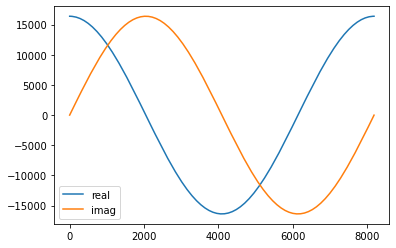

In [58]:
iq_data_components = get_components(iq_data)
plt.plot(list(range(N)), iq_data_components['real'], label='real')
plt.plot(list(range(N)), iq_data_components['imag'], label='imag')
plt.legend()

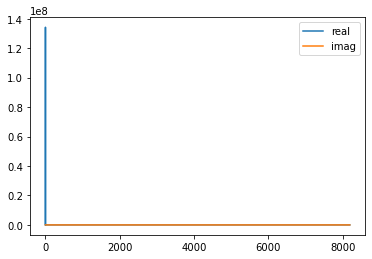

In [59]:
iq_fft = np.fft.fft(iq_data_components['real'] + iq_data_components['imag']*1j)
plt.plot(list(range(N)), iq_fft.real, label='real')
plt.plot(list(range(N)), iq_fft.imag, label='imag')
plt.legend()

In [60]:
# send configs to ffts
fft_config = allocate(1, dtype=np.uint16)
fft_config[0] = 0

In [74]:
dma_1.sendchannel.transfer(fft_config)
dma_1.sendchannel.wait()

In [75]:
dma_0.recvchannel.transfer(res_data)
dma_0.sendchannel.transfer(iq_data)
dma_0.sendchannel.wait()
dma_0.recvchannel.wait()

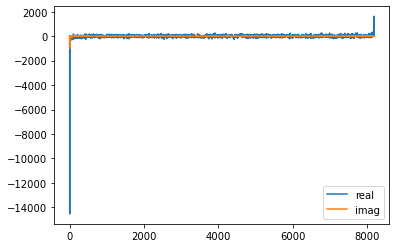

In [76]:
components = get_components(res_data)
plt.plot(list(range(N)), components['real'], label='real')
plt.plot(list(range(N)), components['imag'], label='imag')
plt.legend()

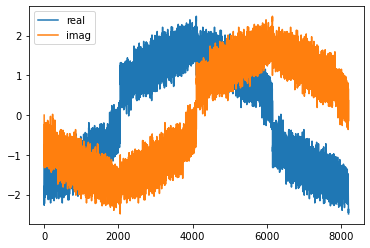

In [77]:
proposed_inputs = np.fft.ifft(components['real'] + components['imag']*1j)
plt.plot(list(range(N)), proposed_inputs.real, label='real')
plt.plot(list(range(N)), proposed_inputs.imag, label='imag')
plt.legend()